In [1]:
import torch
from torch import nn

import torch.functional as F
import torchvision.transforms.functional as TF
import torch.utils.checkpoint as checkpoint

from PIL import Image

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import requests
import io

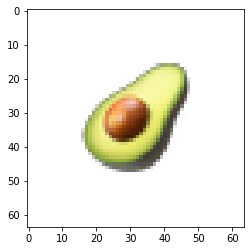

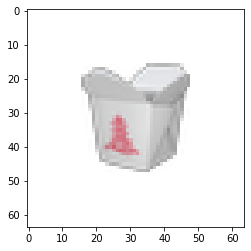

In [2]:
def load_image(url, max_size=32, padding=16):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    img = np.pad(img,((padding,padding),(padding,padding),(0,0)))
    
    img[..., :3] *= img[..., 3:]
    
    img = torch.Tensor(img).float().cuda()
    img = img.transpose(0,2)

    return img


def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://raw.githubusercontent.com/iamcal/emoji-data/master/img-apple-64/%s.png' % code
    return load_image(url)


avocado = load_emoji("🥑")
pineapple = load_emoji("🥡")

plt.imshow(avocado.transpose(0,2).cpu())
plt.show()
plt.imshow(pineapple.transpose(0,2).cpu())
plt.show()

img_size = 64

In [3]:
class Automata(nn.Module):

    def __init__(self, grid_size, n_channels):

        super(Automata, self).__init__()

        self.n_channels = n_channels
        self.grid_size = grid_size

        self.filters = torch.Tensor([[[[-1, 0, 1],
                                       [-2, 0, 2],
                                       [-1, 0, 1]
                                       ]],
                                     [[[-1, -2, -1],
                                       [0, 0, 0],
                                       [1, 2, 1]
                                       ]],
                                     [[[0, 0, 0],
                                       [0, 1, 0],
                                       [0, 0, 0]
                                       ]]]).cuda()

        self.mapper = nn.Sequential(
            nn.Linear(3*n_channels, 128),
            nn.ReLU(),
            nn.Linear(128, n_channels),
            nn.Tanh()
        )

        self.mapper[2].weight.data.fill_(0)
        self.mapper[2].bias.data.fill_(0)

    def perception(self, x):

        # reshape for same convolution across channels
        x = x.reshape(-1, 1, self.grid_size[0], self.grid_size[1])

        # toroidal padding
        conved = nn.functional.pad(x, (1, 1, 1, 1), mode="reflect")

        conved = nn.functional.conv2d(conved, model.filters)

        # reshape for perception computations
        conved = conved.view(self.batch_size, 3*self.n_channels, -1)
        conved = conved.transpose(1, 2)

        conved = self.mapper(conved)

        conved = conved.transpose(1, 2)
        # (batch_size, channels, total_cells)

        conved = conved.view(self.batch_size, self.n_channels, *self.grid_size)

        can_update = torch.rand_like(conved) < 0.5

        return conved*can_update

    def forward(self, x, iterations, keep_history=False):

        if keep_history:

            model.history = torch.zeros(iterations, *x.shape)

        model.batch_size = x.shape[0]
        
        x.requires_grad = True

        for i in range(iterations):

            x = x + checkpoint.checkpoint(self.perception,x)
#             x = x+self.perception(x)

            is_alive = nn.functional.max_pool2d(
                x[:, 3], (3, 3), stride=1, padding=1) > 1/8

            is_alive = is_alive.unsqueeze(1)

            x = x*is_alive

            x[:, :4].clamp_(0, 1)

            if keep_history:

                model.history[i] = x.detach()

        return x

In [6]:
n_channels = 16
n_epochs = 1000
lr = 0.01
pool_size = 1024
batch_size = 32

image_1 = avocado
image_2 = pineapple

images = torch.stack([image_1,image_2])

model = Automata((64, 64), n_channels).cuda()

# initialize pool with seeds
seed = torch.zeros(n_channels,img_size,img_size).cuda()
seed[3:,32,32] = 1

pool_initials = seed[None, :].repeat(pool_size,1,1,1)
pool_targets = image_1[None,:].repeat(pool_size,1,1,1)

pool_target_ids = torch.zeros(pool_size).long()
# 0 for image_1, 1 for image_2

losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):
    
#     iterations = random.randint(64,96)
    iterations = 100

    pool_indices = torch.Tensor(random.sample(range(pool_size),batch_size)).long()
        
    initial_states = pool_initials[pool_indices]
    targets = pool_targets[pool_indices]
    target_ids = pool_target_ids[pool_indices]

    out = model(initial_states,iterations)
    
    phenotypes = out[:,:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)
    
    per_sample_loss = loss.mean((1,2,3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()
    
    # argsort the losses per sample
    ranked_loss = per_sample_loss.argsort()
    
    # get indices of min- and max-loss samples
    min_loss_indices = ranked_loss[:batch_size//2]
    max_loss_indices = ranked_loss[batch_size//2:]
    
    # switch the min-loss samples
    
#     for swap_idx in min_loss_indices:
#         pool_idx = pool_indices[swap_idx]
#         target_id = int(pool_target_ids[pool_idx])
        
#         # if output is the first image,
#         # switch the target to the second
#         if target_id == 1:
#             pool_targets[pool_idx] = image_2
#             pool_target_ids[pool_idx] = 2

#         # if output is the second image,
#         # keep it
#         if target_id == 2:
#             pool_targets[pool_idx] = image_2
#             pool_target_ids[pool_idx] = 2
    
    replacements = out.detach()
    replacements[max_loss_indices] = seed.clone()
    
    # high-loss outputs are re-tasked with
    # mapping the seed to the first image,
    
    # low-loss outputs are tasked with mapping
    # mapping to the other image
    pool_target_ids[pool_indices[max_loss_indices]] = 0
    pool_target_ids[pool_indices[min_loss_indices]] = 1-pool_target_ids[pool_indices[min_loss_indices]]
    
    pool_targets[pool_indices[max_loss_indices]] = images[0]
    pool_targets[pool_indices[min_loss_indices]] = images[pool_target_ids[pool_indices[min_loss_indices]]]

    pool_initials[pool_indices] = replacements

    if i % 100 == 0:
    
        print(i, np.log10(float(total_loss.cpu().detach())))
        
    losses.append(float(total_loss))

0 -1.0723602581784166
100 -1.7044543429957506
200 -2.007311301770268
300 -2.111446301337585
400 -2.345088739289382
500 -2.453818373404251
600 -2.4886760586706216
700 -2.5981246927580166
800 -2.6360172606136976
900 -2.6531910265263896


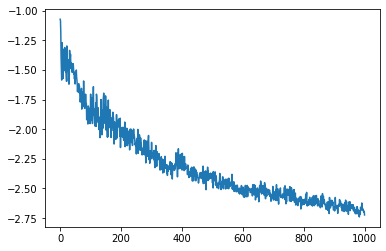

In [7]:
plt.plot(np.log10(losses))

In [8]:
with torch.no_grad():
    out = model(seed[None,:],1024,keep_history=True)
    video = model.history.cpu().detach()
    video = video[:,0,:4]
    video = video.transpose(1,3)

/home/khu/anaconda3/envs/cenv/lib/python3.7/site-packages/torch/utils/checkpoint.py:25: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn("None of the inputs have requires_grad=True. Gradients will be None")


In [9]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close()

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init,  frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())